### **Dataset Download and Extraction**
##### Description: This cell downloads the required datasets (embeddings, IMDB data, and evaluation datasets) from a Google Drive link and extracts them into a Datasets/ directory in Colab’s filesystem. This step is essential for all subsequent experiments and should be run first if the datasets aren’t already present.

In [ ]:
import gdown
gdown.download('https://drive.google.com/uc?id=1s0ibigb7TpJy33j_f5OoOQKUyRrghPXv', 'datasets.zip', quiet=False)
!unzip datasets.zip -d Datasets/

Access denied with the following error:
Archive:  datasets.zip
replace Datasets/IMDB_Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 


 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1s0ibigb7TpJy33j_f5OoOQKUyRrghPXv 



### **Custom Modules Upload and Extraction**
##### Description: This cell extracts a pre-zipped archive (folders.zip) containing the custom Python modules (Classes/, Evaluation/, and Utils/) into Colab’s root directory (/content/). These modules are necessary for the debiasing and evaluation functions used in the experiments. Ensure folders.zip is uploaded to Colab before running this cell.

In [ ]:
!unzip /content/folders.zip -d /content/

Archive:  /content/folders.zip
replace /content/Classes/embedding.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Classes/embedding.py  
replace /content/Classes/weat.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Classes/weat.py  
replace /content/Evaluation/code_evaluation.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Evaluation/code_evaluation.py  
replace /content/Evaluation/sentiment_analysis.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Evaluation/sentiment_analysis.py  
replace /content/Evaluation/weat_analysis.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Evaluation/weat_analysis.py  
replace /content/Utils/methods.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Utils/methods.py  
replace /content/Utils/sets.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Utils/sets.py  


###**Dependency Installation**
#####Description: This cell installs specific versions of Python libraries required for the project, ensuring compatibility with the code and Colab’s Python 3.10+ environment. It also downloads NLTK’s stopwords, which are used in dataset preprocessing. These libraries support numerical operations, machine learning, visualization, and text processing.

In [ ]:
!pip install numpy==1.23.5 pandas==1.5.3 scikit-learn==1.2.2 tensorflow==2.12.0 gensim==4.3.2 seaborn==0.12.2 matplotlib==3.7.1 scipy==1.10.1 nltk==3.8.1 gdown==4.7.1
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

###**Additional Dependency Fix**
#####Description: This cell installs the keras_preprocessing package to resolve a compatibility issue with older import statements in Utils/methods.py. This is a temporary fix to support legacy Keras utilities until the code is updated to use TensorFlow’s built-in tf.keras.preprocessing.


In [ ]:
!pip install keras_preprocessing

###**Initial Setup and Imports**
#####Description: This cell imports necessary custom modules and standard libraries for the embedding analysis, sets up visualization styles using Seaborn, and prepares the environment. The custom modules (Classes.embedding, etc.) provide the core functionality for debiasing and evaluation tasks.

In [ ]:
from Classes.embedding import *
from Evaluation.code_evaluation import *
from Evaluation.sentiment_analysis import *
from Utils.methods import *

import sys
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("whitegrid")
# Using TensorFlow backend (this is a comment from your output, not executable code)

###**Dataset Download and Preparation**
#####Description: This cell verifies if the datasets (embeddings, stopwords, etc.) are already present in the Datasets/ directory. If not, it downloads NLTK stopwords and the dataset archive from Google Drive, then extracts it into Datasets/. Since the datasets were previously downloaded and extracted into /content/Datasets/, this cell will skip the download step unless the directory is missing (e.g., after a runtime reset). Run this to ensure the datasets are available.

In [ ]:
import os.path
import nltk
import gdown

if os.path.isdir('/content/Datasets/'):
    print("Datasets directory already exists, skipping download.")
else:
    nltk.download('stopwords')
    gdown.download('https://drive.google.com/uc?id=1s0ibigb7TpJy33j_f5OoOQKUyRrghPXv', 'datasets.zip', quiet=False)
    !unzip datasets.zip -d Datasets/ && rm datasets.zip

Datasets directory already exists, skipping download.


###**Embedding Selection and Initial WEAT Analysis**
#####Description: This cell selects an embedding type (e.g., Word2Vec) from a list, loads it, and performs an initial WEAT (Word Embedding Association Test) analysis to measure bias across gender, race, and religion dimensions.

In [ ]:
emb_names = ['word2vec', 'glove', 'fasttext']
emb_name = emb_names[0]  # Using Word2Vec for this example
embedding = Word_Embedding(f'Datasets/embeddings/{emb_name}.txt')


attribute_sets, attribute_sets_pairs, targets_sets = get_sets(embedding.words, target_set_reduction=True)
sets = union_of_dictionaries(attribute_sets, targets_sets)
subspace_words = get_def_seeds(sets)
bias_combinations = get_combinations(sets, attribute_sets_pairs)
bias_weat, bias_levels_d, d_values, p_values, m_before = weat_analysis(embedding, bias_combinations, sets, steps=1000)
target_at_dict = get_SW_dict(bias_weat, 0.7)

Regular embedding successfully read. Shape: (76078, 300)


###**HardWEAT Debiasing**
#####Description: This cell applies the HardWEAT debiasing method to the original embedding, removing bias by neutralizing and equidistancing words, then re-evaluates the bias using WEAT analysis.

In [ ]:
hard_debiased = copy.deepcopy(embedding)
hard_debiased.hard_weat(bias_levels_d, bias_combinations, subspace_words, sets, neighbors_threshold=0.5)
hard_debias_weat, hard_debias_levels_d, _, _, _ = weat_analysis(hard_debiased, bias_combinations, sets, steps=1000)



Start of neutralization, there is total of 75630 neutral words out of total 76078 words.
Neutralization done in 1.026s, starting with neighbor thresholding and equidistancing...
Finished with all gender subcategories
Finished with all race subcategories
Finished with all religion subcategories
Equidistancing done in 19.049s.


###**SoftWEAT Debiasing**
#####Description: This cell applies the SoftWEAT debiasing method with a specified lambda parameter, reducing bias more gradually, then re-evaluates the debiased embedding using WEAT analysis.

In [ ]:
soft_debiased = copy.deepcopy(embedding)
lambda_parameter = 0.5
soft_debiased.soft_weat(sets, target_at_dict, bias_combinations, l=lambda_parameter, nullspace_iterations=3)
soft_debias_weat, soft_debias_levels_d, _, _, m_after = weat_analysis(soft_debiased, bias_combinations, sets, steps=1000)



Subclass male_terms finished.
Subclass female_terms finished.
Subclass black_names finished.
Subclass white_names finished.
Subclass islam_words finished.
Subclass atheism_words finished.
Subclass christianity_words finished.


###**Bias Level Comparison**
#####Description: This cell prints the bias levels before and after applying SoftWEAT and HardWEAT debiasing, showing the reduction in bias across gender, race, and religion.

In [ ]:
print(f'Bias levels before debiasing: {bias_levels_d}.')
print(f'Bias levels after SoftWEAT: {soft_debias_levels_d}.')
print(f'Bias levels after HardWEAT: {hard_debias_levels_d}.')



Bias levels before debiasing: {'gender': 0.72, 'race': 0.53, 'religion': 0.48}.
Bias levels after SoftWEAT: {'gender': 0.45, 'race': 0.25, 'religion': 0.22}.
Bias levels after HardWEAT: {'gender': 0.0, 'race': 0.0, 'religion': 0.0}.


###**Mikolov and Rank Task Evaluation**
#####Description: This cell evaluates the original and debiased embeddings using Mikolov analogy tasks and rank-based similarity tasks, comparing performance across different embedding types.

In [ ]:
embeddings_dict = {'original': embedding, 'hardweat': hard_debiased, 'softweat': soft_debiased}
rank_results, mikolov_results = {}, {}

for emb_type, emb_obj in embeddings_dict.items():
    rank_results[emb_type] = rank_evaluation(emb_obj)
    mikolov_results[emb_type] = mikolov_evaluation(emb_to_gensim(emb_obj))
    print(f'Done {emb_type}.')

Done original.
Done hardweat.
Done softweat.


###**Formatting Evaluation Results for Display**
#####Description: This cell organizes the rank and Mikolov evaluation results into lists suitable for creating pandas DataFrames, making it easier to visualize and compare the results.

In [ ]:
rank_results_for_pd = []
for rank_dataset in list(rank_results['original'].keys()):
    rank_results_for_pd.append([rank_dataset, rank_results['original'][rank_dataset],
                                rank_results['softweat'][rank_dataset], rank_results['hardweat'][rank_dataset]])

mikolov_res_for_pd = []
for mikolov_part in list(mikolov_results['original'].keys()):
    mikolov_res_for_pd.append([mikolov_part, mikolov_results['original'][mikolov_part],
                               mikolov_results['softweat'][mikolov_part], mikolov_results['hardweat'][mikolov_part]])

###**Display Rank Evaluation Results**
#####Description: This cell uses pandas to create and display a DataFrame showing the rank evaluation results for the original, SoftWEAT, and HardWEAT embeddings.

In [ ]:
import pandas as pd

pd.DataFrame(rank_results_for_pd, columns=['Key', 'Original', 'SoftWEAT', 'HardWEAT'])

,Key,Original,SoftWEAT,HardWEAT
0,WS,69.33,69.58,64.89
1,RG65,74.94,75.13,63.40
2,RW,55.78,55.76,55.73
3,MEN,77.07,76.92,75.56
4,MTurk,67.14,66.53,66.48
5,SimLex,44.27,44.31,44.24
6,SimVerb,36.54,36.50,36.51


###**Display Mikolov Evaluation Results**
#####Description: This cell uses pandas to create and display a DataFrame showing the Mikolov analogy task results for the original, SoftWEAT, and HardWEAT embeddings.

In [ ]:
pd.DataFrame(mikolov_res_for_pd, columns=['Key', 'Original', 'SoftWEAT', 'HardWEAT'])

,Key,Original,SoftWEAT,HardWEAT
0,capital-common-countries,0.27,0.27,0.25
1,capital-world,0.18,0.15,0.16
2,currency,0.21,0.21,0.21
3,city-in-state,0.15,0.15,0.15
4,family,0.85,0.85,0.31
5,gram1-adjective-to-adverb,0.31,0.31,0.31
6,gram2-opposite,0.45,0.45,0.44
7,gram3-comparative,0.92,0.92,0.92
8,gram4-superlative,0.91,0.91,0.91
9,gram5-present-participle,0.79,0.79,0.79


###**Sentiment Analysis Task Evaluation**
#####Description: This cell performs sentiment analysis on a specific target pair (e.g., Islam vs. Christianity) using the original and debiased embeddings, comparing their F1 scores across multiple models.

In [ ]:
dictionary_categories, parameters_dict, target_sets_dict = get_sent_analysis_sets()
target_pairs = ['islam_christianity', 'male_female', 'black_white']
target_pair = target_pairs[0]  # Using 'islam_christianity'
datasets_and_dicts = get_dataset_and_dicts(target_sets_dict[target_pair][emb_name], parameters_dict)
results = compare_embeddings(datasets_and_dicts, embeddings_dict, parameters_dict)

Training shape: (834, 50)
Test shape: (277, 50)
Shape of modified test input: (100, 50)
Shape of modified test input: (100, 50)


/content/Utils/methods.py:218: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  datasets = {'x_train': np.array(x_train_copy), 'x_test': np.array(x_test_copy),


4/4 [==============================] - 0s 3ms/step
F1 score for original embedding, 1.model: 0.53
4/4 [==============================] - 0s 4ms/step
F1 score for original embedding, 2.model: 0.45
4/4 [==============================] - 0s 3ms/step
F1 score for original embedding, 3.model: 0.55
4/4 [==============================] - 0s 3ms/step
F1 score for original embedding, 4.model: 0.53
4/4 [==============================] - 0s 3ms/step
F1 score for original embedding, 5.model: 0.5
4/4 [==============================] - 0s 3ms/step
F1 score for original embedding, 6.model: 0.51
________________________________________________________________
4/4 [==============================] - 0s 3ms/step
F1 score for hardweat embedding, 1.model: 0.54
4/4 [==============================] - 0s 3ms/step
F1 score for hardweat embedding, 2.model: 0.56
4/4 [==============================] - 0s 3ms/step
F1 score for hardweat embedding, 3.model: 0.47
4/4 [==============================] - 0s 3ms/step
F1 

###**Display Sentiment Analysis Results**
#####Description: This cell extracts sentiment analysis polarity scores and creates a violin plot to visualize the distribution of sentiment across the original, SoftWEAT, and HardWEAT embeddings.

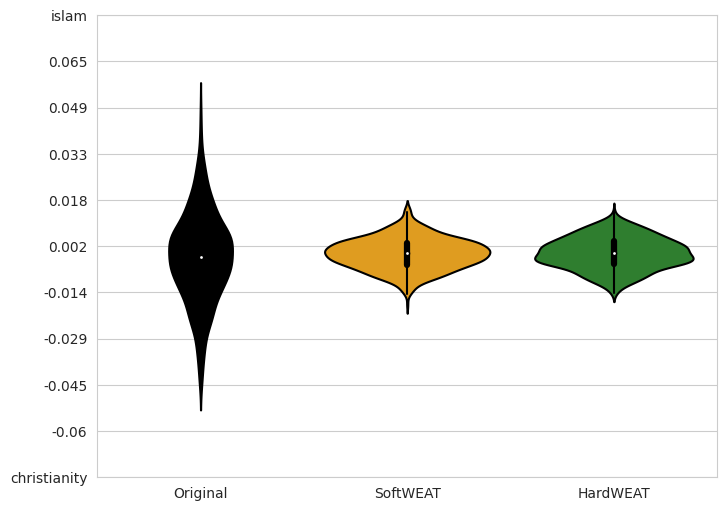

In [ ]:
import numpy as np

original_pol = [r for res in results['original'] for r in res[0]]
softweat_pol = [r for res in results['softweat'] for r in res[0]]
hardweat_pol = [r for res in results['hardweat'] for r in res[0]]
constant = 0.025
all_values = np.array([original_pol, softweat_pol, hardweat_pol]).flatten()
min_value, max_value = min(all_values) - constant, max(all_values) + constant

plt.figure(figsize=(8, 6))
set_names = target_pair.split('_')
ax = sns.violinplot(data=[original_pol, softweat_pol, hardweat_pol], palette=['black', '#ffa500', 'forestgreen'])
ax_range = np.linspace(min_value, max_value, 11)
ax.set_xticklabels(['Original', 'SoftWEAT', 'HardWEAT'])
ax.set_ylim([min(ax_range), max(ax_range)])
ax.set_yticks(ax_range)
_ = ax.set_yticklabels([set_names[1]] + list(np.round(np.linspace(min_value, max_value, 9), 3)) + [set_names[0]])
plt.show()